In [1]:
import datetime
import os
import sys
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
import dataframe_image as dfi
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


notebook_dir = os.path.abspath(os.getcwd())
src_path = os.path.join('/home/lerceg/LukaPosao/market_models/', 'src')
sys.path.append(src_path)

import market_models.src.models.train_model as tm
import market_models.src.models.predict_model as pm
import market_models.src.utils as utils

%load_ext autoreload
%autoreload 
import market_models.src.features.build_features as build_features


For the base profiles,  base profile one should be Toyota Corolla with 0 years old, 40 years old, b10 bonus malus so no damages, 1100 postal code, 60 km and then we change just one dimension at a time:
(1) all postal codes with population bigger then 1000 people 
(2) all kw in 5 kw steps 
(3) years old with 2 year steps 
(4) car age 
(5) previous damage 


In [2]:
other_path = utils.get_others_path("netrisk_casco")
eurotax = pd.read_csv(f"{other_path}full_trim_list.csv", low_memory = False)
prices = pd.read_csv(f"{other_path}price.csv", low_memory = False)[['eurotax_code', 'new_price_1_gross']]

eurotax = pd.merge(eurotax, prices, on = 'eurotax_code')
eurotax['new_price_1_gross'] *= utils.FORINT_TO_EUR 
eurotax = eurotax[eurotax['vehicle_type'] == 10]
netrisk_cars = pd.read_csv(f"{other_path}netrisk_cars.csv", low_memory = False)


In [3]:
netrisk_cars

,Unnamed: 0,eurotax_code,car_make_year,car_make_year_code,car_make,car_make_code,car_model,car_model_code,car_trim_id,car_trim_name,car_full_name,kw,ccm,kg,car_value
0,0,0280B012,2022,2,ALFA ROMEO,3,Giulia,2,1,Giulia 2.0 Sprint Aut.,ALFA ROMEO_Giulia_2.0 Sprint Aut.,148,1995,1429,17790000.0
1,1,0279B003,2022,2,ALFA ROMEO,3,Giulia,2,2,Giulia 2.0 Super Aut.,ALFA ROMEO_Giulia_2.0 Super Aut.,148,1995,1429,10991000.0
2,2,0279B003,2021,3,ALFA ROMEO,3,Giulia,2,4,Giulia 2.0 Super Aut.,ALFA ROMEO_Giulia_2.0 Super Aut.,148,1995,1429,10991000.0
3,3,0279B003,2020,4,ALFA ROMEO,3,Giulia,2,4,Giulia 2.0 Super Aut.,ALFA ROMEO_Giulia_2.0 Super Aut.,148,1995,1429,10991000.0
4,4,0279B003,2020,4,ALFA ROMEO,3,Giulia,2,5,Giulia 2.0 Super Aut.,ALFA ROMEO_Giulia_2.0 Super Aut.,148,1995,1429,10991000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42231,42231,9620B001,1994,30,ZAZ,138,Tavria,2,6,Tavria Cabrio 1.1 Cabrio,ZAZ_Tavria Cabrio_1.1 Cabrio,39,1091,880,769900.0
42232,42232,9620B001,1993,31,ZAZ,138,Tavria,2,5,Tavria Cabrio 1.1 Cabrio,ZAZ_Tavria Cabrio_1.1 Cabrio,39,1091,880,769900.0
42233,42233,9610B002,1994,30,ZAZ,138,Tavria,2,3,Tavria 1.1 Happy,ZAZ_Tavria_1.1 Happy,39,1091,880,519900.0
42234,42234,9610B002,1993,31,ZAZ,138,Tavria,2,3,Tavria 1.1 Happy,ZAZ_Tavria_1.1 Happy,39,1091,880,519900.0


In [4]:
netrisk_cars = netrisk_cars.drop_duplicates('eurotax_code')
netrisk_cars = netrisk_cars[(netrisk_cars['car_trim_id'] == 1) & (netrisk_cars['car_make_year'] >= 2014)]

In [5]:
netrisk_cars

,Unnamed: 0,eurotax_code,car_make_year,car_make_year_code,car_make,car_make_code,car_model,car_model_code,car_trim_id,car_trim_name,car_full_name,kw,ccm,kg,car_value
0,0,0280B012,2022,2,ALFA ROMEO,3,Giulia,2,1,Giulia 2.0 Sprint Aut.,ALFA ROMEO_Giulia_2.0 Sprint Aut.,148,1995,1429,17790000.0
27,27,0280B010,2021,3,ALFA ROMEO,3,Giulia,2,1,Giulia 2.0 6C Villa d'Este Aut.,ALFA ROMEO_Giulia_2.0 6C Villa d'Este Aut.,148,1995,1429,17600000.0
34,34,0209B001,2021,3,ALFA ROMEO,3,Giulietta,3,1,Giulietta 1.4 TB Giulietta,ALFA ROMEO_Giulietta_1.4 TB Giulietta,88,1368,1355,6620000.0
45,45,0279B002,2020,4,ALFA ROMEO,3,Giulia,2,1,Giulia 2.0 Aut.,ALFA ROMEO_Giulia_2.0 Aut.,148,1995,1429,10491000.0
54,54,0209B013,2020,4,ALFA ROMEO,3,Giulietta,3,1,Giulietta 1.4 TB Executive,ALFA ROMEO_Giulietta_1.4 TB Executive,88,1368,1355,6819000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40753,40753,9011B021,2014,10,VOLKSWAGEN,132,Golf,3,1,Golf VI Variant 1.2 TSI Trendline,VOLKSWAGEN_Golf VI Variant_1.2 TSI Trendline,77,1197,1293,5195800.0
40756,40756,9008B020,2014,10,VOLKSWAGEN,132,Golf Plus,4,1,Golf VI Plus 1.2 TSI Comfortline,VOLKSWAGEN_Golf VI Plus_1.2 TSI Comfortline,77,1197,1281,5661890.0
40801,40801,9015B003,2014,10,VOLKSWAGEN,132,New Beetle,7,1,Beetle 1.2 TSI Design,VOLKSWAGEN_Beetle_1.2 TSI Design,77,1197,1199,5275810.0
40840,40840,9006B001,2014,10,VOLKSWAGEN,132,Scirocco,11,1,Scirocco 1.4 TSI,VOLKSWAGEN_Scirocco_1.4 TSI,118,1390,1271,7431000.0


In [12]:
base_profile = utils.read_file(utils.get_profiles_for_crawling_transposed("netrisk_casco_sampled_data"))

In [13]:
base_profile[(base_profile['CarModel'] == 'Corolla')]

,Unnamed: 0,Age,isRecent,LicenseAge,PostalCode,BonusMalus,BonusMalusCode,kw,CarMake,CarAge,...,kg,car_value,postal_code,Latitude,Longitude,Category,PostalCode2,PostalCode3,CarMakerCategory,PolicyStartDate
78,78,77,True,18,1039,B10,1,73,TOYOTA,7,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
89,89,57,True,18,4220,B03,8,73,TOYOTA,5,...,1270,14898.0,4220,47.6667,21.5167,7.0,42,422,1,2023_01_01
157,157,41,True,18,4171,B10,1,85,TOYOTA,4,...,1400,26832.0,4171,47.2333,21.2000,7.0,41,417,1,2023_01_01
349,349,73,True,18,6008,B07,4,73,TOYOTA,5,...,1225,12792.0,6008,46.9062,19.6913,6.0,60,600,1,2023_01_01
501,501,30,True,18,2523,B10,1,73,TOYOTA,10,...,1245,14339.0,2523,47.6770,18.6793,4.0,25,252,1,2023_01_01
587,587,36,True,18,1085,B10,1,73,TOYOTA,8,...,1245,14274.0,1085,47.4984,19.0404,1.0,10,108,1,2023_01_01
765,765,49,True,18,4735,B10,1,73,TOYOTA,5,...,1225,12792.0,4735,47.9056,22.6278,8.0,47,473,1,2023_01_01
766,766,49,True,18,4735,B10,1,73,TOYOTA,5,...,1225,12792.0,4735,47.9077,22.6098,8.0,47,473,1,2023_01_01


In [14]:
base_profile = base_profile.iloc[78]

In [15]:
base_profile

Unnamed: 0                  78
Age                         77
isRecent                  True
LicenseAge                  18
PostalCode                1039
BonusMalus                 B10
BonusMalusCode               1
kw                          73
CarMake                 TOYOTA
CarAge                       7
CarModel               Corolla
CarModelSpecific             5
ccm                       1329
kg                        1225
car_value              12558.0
postal_code               1039
Latitude               47.4984
Longitude              19.0404
Category                   1.0
PostalCode2                 10
PostalCode3                103
CarMakerCategory             1
PolicyStartDate     2023_01_01
Name: 78, dtype: object

In [16]:
base_profile['Age'] = 35
base_profile['CarAge'] = 1
base_profile['BonusMalus'] = 'B10'
base_profile['BonusMalusCode'] = 1
base_profile['PostalCode'] = 1011
base_profile['CarModelSpecific'] = 1

In [17]:
base_profile.to_csv(utils.get_incremental_base_profile_path("netrisk_casco", "v1"))

In [6]:
postal_codes = pd.read_csv(f'{utils.get_others_path("netrisk_casco")}hungary_postal_codes.csv')['postal_code']

In [13]:
population = pd.read_csv(f'{utils.get_others_path("netrisk_casco")}hungary_postal_codes_population.csv').rename(columns = {'PostalCode' : 'postal_code',
'Population' : 'population'})[['postal_code', 'population']]

In [14]:
def to_int(x):
    try:
        return int(str(x).replace(',', ''))
    except Exception as e:
        return None
population['population'] = population['population'].apply(to_int) 
population = population.dropna()
population = population[population['population'].between(2000, 10000)]

In [16]:
population

,postal_code,population
1,1011,5052.0
2,1012,2905.0
3,1013,6066.0
4,1014,2594.0
5,1015,3407.0
...,...,...
3287,9791,2061.0
3294,9798,2538.0
3296,9800,4375.0
3321,9915,2064.0


In [24]:
postal_codes = population['postal_code'].values.tolist()

In [25]:
values = pd.DataFrame(columns = ['feature', 'min', 'max', 'step', 'values'])

In [26]:
#features_to_vary = pd.Series(['PostalCode', 'Age', 'CarAge', 'BonusMalus', ('CarAge', 'CarMake', 'CarModel', 'CarModelSpecific')])
features_to_vary = pd.Series(['PostalCode'])

In [27]:
car_values = netrisk_cars[['car_make_year', 'car_make', 'car_model', 'car_trim_id']].values
car_values[ : , 0]  = datetime.datetime.today().year - car_values[ : , 0] 
car_values = list(map(tuple, car_values))

In [29]:
#feature_values = pd.Series([postal_codes, None, None, utils.BONUS_MALUS_CLASSES_GOOD, car_values])
feature_values = pd.Series([postal_codes])

In [30]:
values['values'] = feature_values
values['feature'] = features_to_vary
#values['min'] = pd.Series([None, 18, 0, None, None])
#values['max'] = pd.Series([None, 80, 10, None, None])
#values['step'] = pd.Series([None, 2, 1, None, None])

In [31]:
values

,feature,min,max,step,values
0,PostalCode,NaN,NaN,NaN,"[1011, 1012, 1013, 1014, 1015, 1016, 1021, 102..."


In [32]:
values.to_csv(utils.get_incremental_values_path("netrisk_casco", "v4"))

In [52]:
for i in range(30, 245, 5):

    required_kws = [i, i + 5]
    def has_required_kws(group):
        return all(kw in group['performance'].values for kw in required_kws)
    
    def min_diff_group(group):
        values = group['new_price_1_gross'].values
        if len(values) < 2:
            return group
        min_diff_idx = abs(values[0] - values[1]).argmin()
        return group.iloc[min_diff_idx:min_diff_idx+2]
    try:
        filtered_groups = eurotax.groupby('model_series_name_1', group_keys = True).filter(has_required_kws).groupby('model_series_name_1', group_keys = True)
        model = filtered_groups.apply(min_diff_group).reset_index(drop = True).groupby("model_series_name_1", group_keys = True)['new_price_1_gross'].agg(np.ptp).idxmin()
        print(filtered_groups[model])
    except:
        print("No models")

No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models
No models


In [122]:
d = pd.read_csv(utils.get_profiles_for_crawling_transposed(utils.get_incremental_data_name('netrisk_casco', 'v1', 'v3')))

In [125]:
d

,Unnamed: 0.1,Unnamed: 0,Age,isRecent,LicenseAge,PostalCode,BonusMalus,BonusMalusCode,kw,CarMake,...,kg,car_value,postal_code,Latitude,Longitude,Category,PostalCode2,PostalCode3,CarMakerCategory,PolicyStartDate
0,data,78,35,True,18,1025,B10,1,73,TOYOTA,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
1,data,78,35,True,18,1026,B10,1,73,TOYOTA,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
2,data,78,35,True,18,1028,B10,1,73,TOYOTA,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
3,data,78,35,True,18,1031,B10,1,73,TOYOTA,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
4,data,78,35,True,18,1033,B10,1,73,TOYOTA,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,data,78,35,True,18,1011,B10,1,73,VOLKSWAGEN,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
874,data,78,35,True,18,1011,B10,1,73,VOLKSWAGEN,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
875,data,78,35,True,18,1011,B10,1,73,VOLKSWAGEN,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01
876,data,78,35,True,18,1011,B10,1,73,VOLKSWAGEN,...,1225,12558.0,1039,47.4984,19.0404,1.0,10,103,1,2023_01_01


In [123]:
d.nunique()

Unnamed: 0.1          1
Unnamed: 0            1
Age                  32
isRecent              1
LicenseAge            1
PostalCode          228
BonusMalus           15
BonusMalusCode        1
kw                    1
CarMake              45
CarAge               10
CarModel            336
CarModelSpecific      1
ccm                   1
kg                    1
car_value             1
postal_code           1
Latitude              1
Longitude             1
Category              1
PostalCode2           1
PostalCode3           1
CarMakerCategory      1
PolicyStartDate       1
dtype: int64

In [40]:
def prepareDir(dir):
    if not os.path.isdir(dir):
        os.mkdir(dir)
    for file in os.listdir(dir):
        os.remove(dir + file)

In [17]:
####### PATHS
data_name = 'netrisk_casco_2023_11_14__2023_11_20__2023_12_12'
target_variable = 'ALFA_price'

model_name = utils.get_model_name(data_name, target_variable)

data_path = utils.get_processed_data_path(data_name)
features_path = utils.get_features_path(data_name)
model_path = utils.get_model_path(model_name)

data, features = utils.load_data(data_path, features_path, target_variable)
model = utils.load_model(model_path)

In [18]:
data

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price
0,True,28,2,998,49,899,15337.400,1.00,1016,10,101,2,19.0404,47.4984,39,18,1.0,2,156948.0
1,True,20,1,999,92,1280,24388.000,1.00,1016,10,101,2,19.0404,47.4984,48,18,0.0,1,232728.0
2,True,12,2,999,54,974,6757.400,0.97,1016,10,101,2,19.0404,47.4984,26,18,0.0,1,133356.0
3,True,23,2,998,49,996,8447.400,0.97,1016,10,101,2,19.0404,47.4984,56,18,7.0,8,165864.0
4,True,58,2,999,59,1270,11568.336,1.00,1016,10,101,2,19.0404,47.4984,42,18,7.0,8,176712.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,True,58,1,999,59,1270,11568.336,1.00,8685,86,868,7,17.7621,46.6214,62,18,0.0,1,119208.0
3102,True,56,6,999,44,940,NaN,1.00,2629,26,262,5,18.8725,47.8640,75,18,7.0,8,80772.0
3103,True,12,10,1598,77,1171,9152.000,0.97,9093,90,909,5,17.8000,47.5000,31,18,0.0,1,64932.0
3104,True,70,4,999,59,1120,11459.370,1.00,9133,91,913,5,17.4185,47.5383,55,18,0.0,1,75780.0


In [19]:
train_data, test_data = train_test_split(data, test_size=tm.TEST_SIZE, random_state=tm.RANDOM_STATE)

In [20]:


def plot_feature_distribution(feature: pd.Series) -> None:
    plt.figure(figsize=(10, 6))
    
    if feature.dtype == 'bool':
        sns.countplot(data=data, x=feature.name)
        plt.title(f'Distribution of {feature.name}')
    else:
        sns.histplot(feature, bins=40, kde=False, stat='density', alpha=0.7)
        plt.title(f'Distribution of {feature.name}')
        plt.xlabel(feature.name)
        plt.ylabel('Percent of values')
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.locator_params(axis = 'x', nbins = 20)
        plt.xticks(rotation=45, ha='right')

    plt.savefig(f'{feature.name}_Distribution.jpg', bbox_inches='tight')
    plt.close()


In [21]:
plot_feature_distribution(data['PostalCode'])

In [22]:
def make_data_overview(data : pd.DataFrame) -> None:
    unique = pd.DataFrame(data.nunique()).rename(columns={0: 'unique'}).T
    describe = pd.concat([data.describe(), unique])
    describeStyle = describe.T.style.format(precision=2)
    dfi.export(describeStyle, 'dataOverview.png', dpi=200)

In [31]:
hyperparameter_ranges = {
    'learning_rate': np.arange(0.01, 0.31, 0.01),
    'n_estimators': np.arange(100, 1100, 100),
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': np.arange(0.5, 1.01, 0.1),
    'colsample_bytree': np.arange(0.5, 1.01, 0.1),
    'gamma': np.arange(0, 0.21, 0.01),
    'lambda': np.arange(0, 1.1, 0.1),
}


def hyperparameter_tuning(data: pd.DataFrame = None,
                          features: list = FEATURES,
                          target_variable: str = TARGET_VARIABLE,
                          params: dict = None,
                          plot_search=False) -> tuple:
    if data is None:
        data = DATA

    if params is None:
        params = DEFAULT_PARAMS.copy()

    best_hyperparameters = {}  # To store the best hyperparameter value for each parameter
    min_mae_values = {}  # To store the corresponding minimum MAE values

    for hp, hp_values in hyperparameter_ranges.items():
        maes = []
        print(f"Iterating over {hp} values...")

        # Initialize the minimum MAE and corresponding hyperparameter value
        min_mae = float('inf')
        best_value = None
        current_params = params
        for value in hp_values:
            current_params[hp] = value
            mae, mse, mape = kFoldCrossValidation(3, data, features, target_variable, params, debug=False)
            maes.append(mae)

            # Check if the current value gives a lower MAE
            if mae < min_mae:
                min_mae = mae
                best_value = value

        # Store the best hyperparameter value in the dictionary
        best_hyperparameters[hp] = best_value
        min_mae_values[hp] = min_mae

        if plot_search:
            # Plot the results
            plt.title(f'Search for optimal {hp} value:')
            plt.plot(hp_values, maes)
            plt.xlabel(f'{hp}')
            plt.ylabel('Mean Absolute Error (MAE)')
            plt.show()

    # Display the best hyperparameter values
    print("\nBest Hyperparameter Values:")
    for hp, value in best_hyperparameters.items():
        print(f"{hp}: {value}")

    mae, mse, mape = kFoldCrossValidation(3, data, features, target_variable, best_hyperparameters, debug=False)

    return best_hyperparameters, mae

In [32]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1300, 100, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(2, 11, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 11, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 0.2),
    'lambda': hp.uniform('lambda', 0, 1),
    'reg_alpha': hp.uniform('reg_alpha', 40, 180),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'seed': 0,
}


def objective(space):
    params = space.copy()
    mae, rmse, mape = kFoldCrossValidation(k=3, param=params, debug=False)
    print(f"Score: {mae}")
    return {"loss": mae, 'status': STATUS_OK}


trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials,
                        return_argmin=False)


Score: 10828.98                                        
Score: 10857.59                                                          
Score: 9942.86                                                           
Score: 10472.09                                                        
Score: 9086.07                                                        
Score: 20281.43                                                       
Score: 11436.15                                                       
Score: 13968.3                                                        
Score: 10801.96                                                       
Score: 9663.6                                                         
Score: 11896.24                                                        
Score: 10769.19                                                        
Score: 14670.85                                                        
Score: 11321.77                                                        
Score: 117

In [78]:
def get_errors(real : pd.Series, predicted : pd.Series,
               quantile_ranges=[0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 1]):
    errors = real - predicted
    absolute_erros = errors.abs()
    relative_errors = errors / real
    errors_q = errors.quantile(quantile_ranges)
    abs_error_q = absolute_erros.quantile(quantile_ranges)
    relative_errors_q = relative_errors.quantile(quantile_ranges) * 100
    abs_relative_erros_q = np.abs(relative_errors).quantile(quantile_ranges) * 100
    quantile_df = pd.DataFrame(index=errors_q.index)
    quantile_df['error_q'] = errors_q
    quantile_df['abs_error_q'] = abs_error_q
    quantile_df['relative_error_q'] = relative_errors_q
    quantile_df['abs_relative_error_q'] = abs_relative_erros_q
    return quantile_df.round(3)


In [84]:
get_errors(data[target_variable], utils.predict(model, data[features]))

,error_q,abs_error_q,relative_error_q,abs_relative_error_q
0.00,-18447.000,0.672,-34.305,0.000
0.01,-10010.298,35.276,-8.476,0.029
0.03,-7305.527,96.583,-6.219,0.079
0.05,-6126.664,167.620,-5.092,0.139
0.10,-4370.036,315.378,-3.652,0.282
0.20,-2674.323,671.080,-2.238,0.569
0.30,-1540.326,1039.276,-1.414,0.901
0.40,-764.337,1444.430,-0.650,1.246
0.50,-42.461,1909.012,-0.035,1.682
0.60,565.641,2527.639,0.493,2.141


In [22]:
kpi_data = [[mae, rmse, mape, round(DATA[TARGET_VARIABLE].mean(), 1)]]
kpi = pd.DataFrame(data=kpi_data, columns=KPI_TABLE_COLUMNS).astype('str')

In [23]:
kpi

,MAE,RMSE,MAPE,Avg target
0,10206.64,20770.91,6.49,134597.4


In [43]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf


class XGBRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, booster, params=None):
        self.booster = booster
        self.params = params

    def fit(self, X, y):
        if self.params:
            dmatrix = xgboost.DMatrix(X, label=y)
            self.booster = xgboost.train(self.params, dmatrix)
        else:
            raise ValueError("XGBoost parameters not provided.")

        return self

    def predict(self, X):
        dmatrix = xgboost.DMatrix(X)
        return self.booster.predict(dmatrix)

In [44]:
sklrean_model = XGBRegressorWrapper(model, best_hyperparams)

In [ ]:
smf

In [ ]:
for col in DATA.columns:
    plotFeatureDistribution(feature=col)

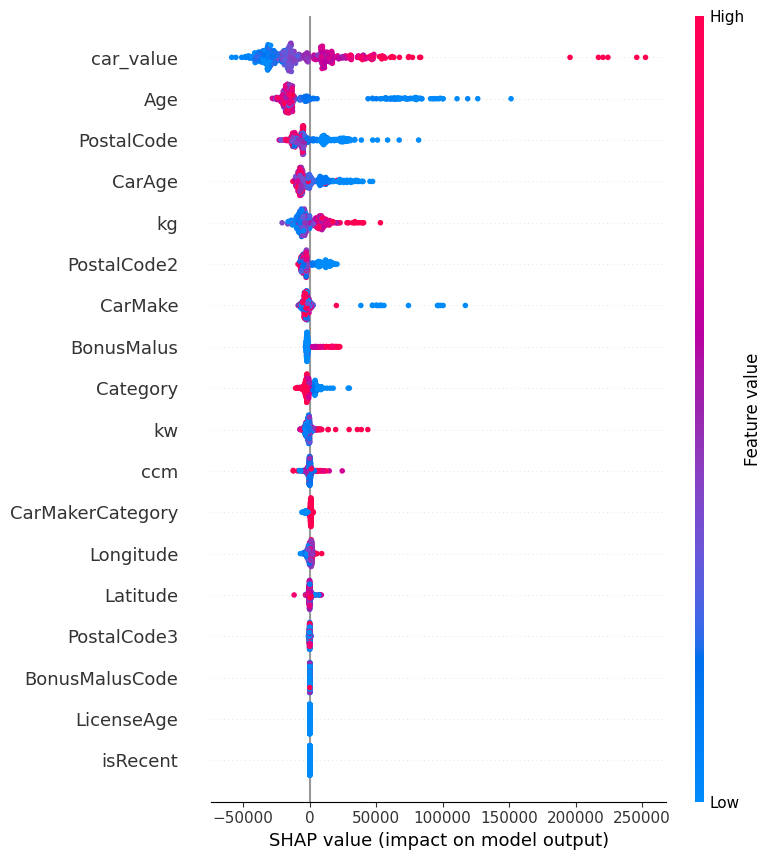

In [40]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(TEST_DATA[FEATURES].values)

shap.summary_plot(shap_values, TEST_DATA[FEATURES], feature_names=FEATURES)

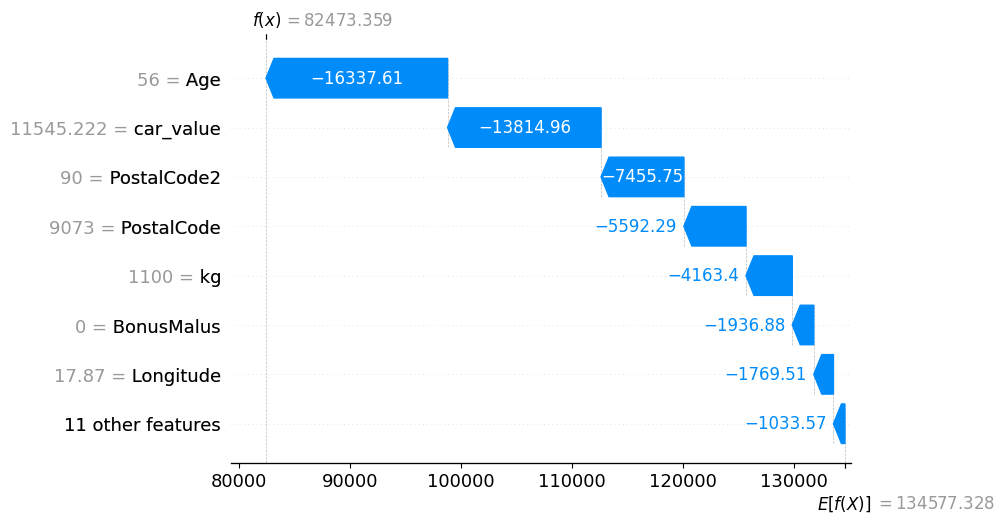

In [41]:
id = 21
plt.figure(figsize=(20, 20))
shap.waterfall_plot(shap.Explanation(values=shap_values[id],
                                     base_values=explainer.expected_value,
                                     data=TEST_DATA.iloc[id],
                                     feature_names=FEATURES),
                    max_display=8)  # Adjust max_display as needed

plt.show()

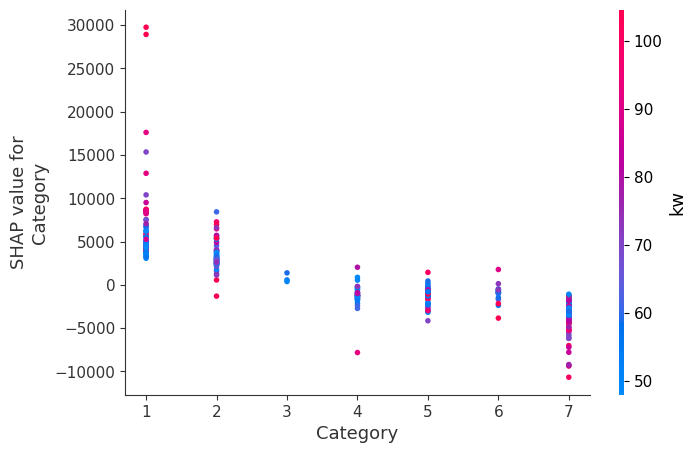

In [42]:
shap.dependence_plot('Category', shap_values, TEST_DATA[FEATURES])

In [87]:
def partial_dependence_analysis(model: xgboost.Booster,
                                data: pd.DataFrame,
                                target_variable : str,
                                feature_names: list,
                                grid_resolution: int = 100) -> tuple:
  
    importance_dict = {}
    pdp_dict = {}

    for feature_name in feature_names:
        if data[feature_name].dtype == 'category':  # Check if the variable is categorical
            unique_values = data[feature_name].unique()
            partial_dependence_values = []

            for value in unique_values:
                data_copy = data.copy()
                data_copy[feature_name] = value
                dmatrix = xgboost.DMatrix(data_copy.drop(target_variable, axis=1))
                predictions = model.predict(dmatrix)
                partial_dependence_values.append(np.mean(predictions))

            importance_dict[feature_name] = np.std(partial_dependence_values)
            pdp_dict[feature_name] = (unique_values, partial_dependence_values)
        else:
            feature_range = np.linspace(data[feature_name].min(), data[feature_name].max(), grid_resolution)
            partial_dependence_values = []

            for value in feature_range:
                data_copy = data.copy()
                data_copy[feature_name] = value
                dmatrix = xgboost.DMatrix(data_copy.drop(target_variable, axis=1))
                predictions = model.predict(dmatrix)
                partial_dependence_values.append(np.mean(predictions))

            importance_dict[feature_name] = np.std(partial_dependence_values)
            pdp_dict[feature_name] = (feature_range, partial_dependence_values)

    return pdp_dict, importance_dict


def plot_importance(features, importances, title="Feature importance", xlabel="Partial Dependence Feature Importance",
                    ylabel="Features", show_values=True, values_format="{:.2f}", save_path=None, **kwargs):
    sorted_indices = np.argsort(importances)
    features = [features[i] for i in sorted_indices]
    importances = [importances[i] for i in sorted_indices]

    # Plotting
    fig, ax = plt.subplots()
    ax.barh(features, importances, **kwargs)

    # Customize plot
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if show_values:
        for i, v in enumerate(importances):
            ax.text(v, i, values_forsave_path = values_format.format(v), va='center')

    if save_path is not None:
        plt.savefig(save_path)
    return ax


In [89]:
pdp_dict, importances = partial_dependence_analysis(model, data, target_variable, features)

In [90]:
importances

{'isRecent': 0.015625,
 'CarMake': 25572.246,
 'CarAge': 14921.833,
 'ccm': 4377.9707,
 'kw': 27985.463,
 'kg': 45175.88,
 'car_value': 45131.734,
 'CarMakerCategory': 572.10693,
 'PostalCode': 5364.749,
 'PostalCode2': 2646.9678,
 'PostalCode3': 4152.037,
 'Category': 2720.1726,
 'Longitude': 4169.19,
 'Latitude': 2054.6394,
 'Age': 35189.734,
 'LicenseAge': 0.015625,
 'BonusMalus': 9874.714,
 'BonusMalusCode': 1536.1864}

TypeError: Axes.text() missing 1 required positional argument: 's'

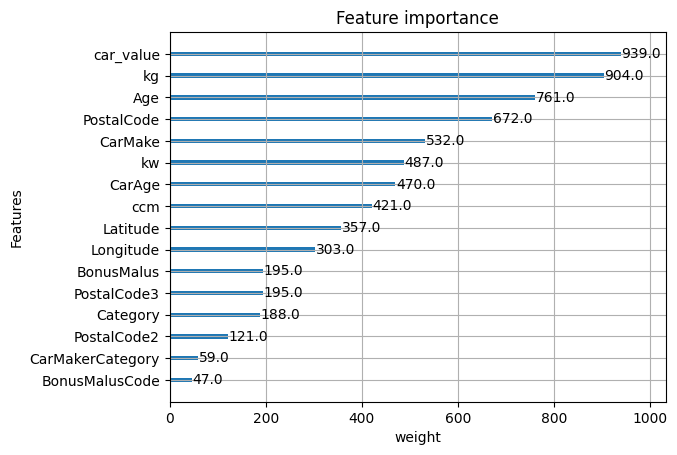

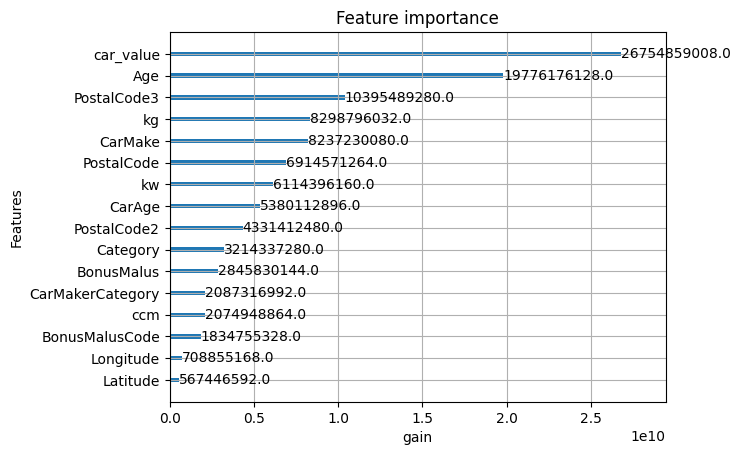

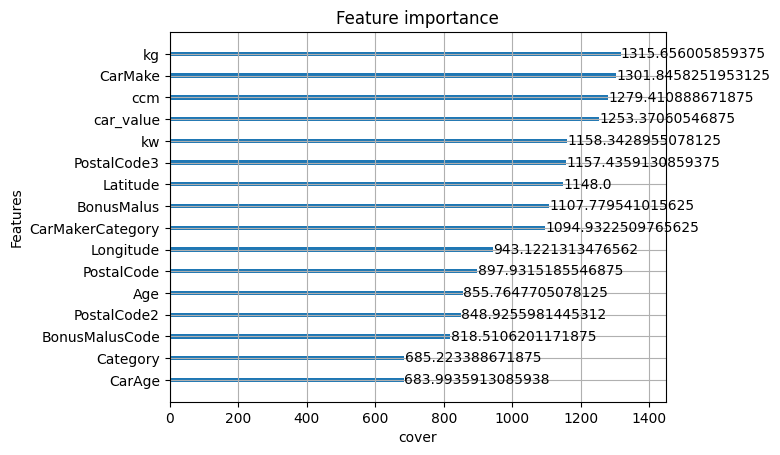

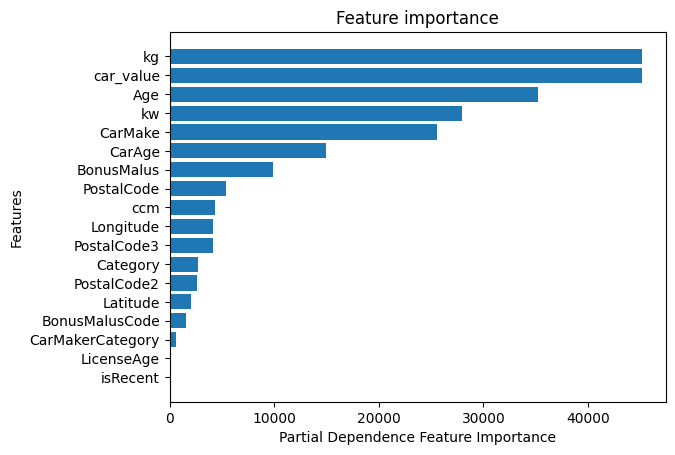

In [91]:
xgboost.plot_importance(model, importance_type='weight', xlabel='weight')
plt.savefig(f'feature_importnace_weight.jpg')
xgboost.plot_importance(model, importance_type='gain', xlabel='gain')
plt.savefig(f'feature_importnace_gain.jpg')
xgboost.plot_importance(model, importance_type='cover', xlabel='cover')
plt.savefig(f'feature_importnace_cover.jpg')
plot_importance(list(importances.keys()), list(importances.values()),
                save_path=f'feature_importnace_pdp.jpg')

In [92]:
for feature in features:
    feature_range, pdp_values = pdp_dict[feature]
    plt.plot(feature_range, pdp_values, label=feature)
    plt.xlabel('Feature Values')
    plt.ylabel('Partial Dependence')
    plt.title('Partial Dependence Plots for Selected Features')
    plt.legend()
    plt.savefig(f'PDPplot{feature}.jpg')
    plt.close()

In [27]:
def getQauntSplit(step=50):
    return [i / 1000 for i in range(0, 1001, step)]


quant = getQauntSplit(int(np.ceil(100000 / len(TRAIN_DATA))))
qr = TEST_DATA[TARGET_VARIABLE].quantile(quant)
qp = pd.Series(model.predict(makeDMatrix(TEST_DATA[FEATURES], TEST_DATA[TARGET_VARIABLE]))).quantile(quant)

plt.scatter(qr, qp, alpha=0.8, s=40)
x = np.linspace(qr.min(), qr.max())
plt.plot(x, x, c='r')
plt.xlabel('Real quantiles for training data')
plt.ylabel('Predicted quantiles for training data')
plt.savefig(KPI_DATA_PATH + 'QQplot.jpg', bbox_inches='tight')
plt.close()

In [29]:
def quantPlot(out, feature, numQuant=20):
    type = True  # Does the feature have more than 20 unique values in train data, 20 because it looks bad with more
    fQuant = None
    cats = None
    if len(out[feature].unique()) > 30 and feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object':
        return
    if len(out[feature].unique()) < numQuant or (
            feature in feature_dtypes.keys() and feature_dtypes[feature] == 'object'):
        out['QuantCat'] = out[feature]
        type = False
    else:
        fQuant = out[feature].quantile(getQauntSplit(1000 // numQuant)).values
        cats = list(pd.Series(fQuant).unique())

        def getQId(x):
            for i in range(0, len(cats) - 1):
                if x >= cats[i] and x <= cats[i + 1]:
                    return i
            return len(cats) - 1

        out['QuantCat'] = out[feature].apply(lambda x: getQId(x))
        cats = [str(round(cats[i], 2)) + "-" + str(round(cats[i + 1], 2)) for i in range(0, len(cats) - 1)]

    agg_age = out.groupby('QuantCat')

    fig, ax = plt.subplots(figsize=(14, 14))
    if type:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker='o', color='b',
                alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean().dropna(), marker='o',
                color='r', alpha=0.6)
        ax.set_xticks(sorted(list(out['QuantCat'].unique())))
    else:
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[TARGET_VARIABLE].mean().dropna(), marker='o', color='b',
                alpha=0.6)
        ax.plot(sorted(list(out['QuantCat'].unique())), agg_age[PRED_TARGET_VARIABLE].mean().dropna(), marker='o',
                color='r', alpha=0.6)
        if feature == 'CarMaker':
            ax.set_xticklabels(sorted([str(x)[:4] for x in list(out['QuantCat'].unique())]))
        else:
            ax.set_xticklabels(sorted(list(out['QuantCat'].unique())))

    plt.title('Mean Real vs Predicted price aggregated by {}'.format(feature))
    ax.legend(['Real', 'Predicted'])
    plt.savefig(KPI_DATA_PATH + 'quantPlot' + col + '.jpg', bbox_inches='tight')
    plt.close()
    ret = pd.DataFrame(agg_age[TARGET_VARIABLE].mean() - agg_age[PRED_TARGET_VARIABLE].mean())
    #print(ret)
    if type:
        #print(cats, out['QuantCat'].unique())
        ret.index = [cats[i] for i in range(len(cats)) if i in out['QuantCat'].unique()]

    return ret


out = merge_predictions(model)
agg_errors = {}
for col in TEST_DATA.columns:
    agg_errors[col] = quantPlot(out, col)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


0      52225.765625
1      59944.039062
2      66795.531250
3      70810.429688
4      75897.890625
5      79672.140625
6      84046.671875
7      90264.023438
8      96304.562500
9     101545.546875
10    105787.265625
11    109715.625000
12    114347.093750
13    119183.453125
14    125324.210938
15    133354.453125
16    140886.718750
17    151377.984375
18    161035.812500
19    173629.640625
20    189718.437500
21    205800.500000
22    228075.093750
23    264012.593750
24    393232.125000
Name: predicted, dtype: float32
0      52352.900000
1      59932.840336
2      66587.394958
3      70317.000000
4      75324.540541
5      79336.487805
6      84234.678261
7      89877.700000
8      95802.545455
9     100969.000000
10    105372.000000
11    109882.315789
12    114740.780488
13    119231.482759
14    125318.600000
15    132300.000000
16    140945.300000
17    150623.596639
18    160594.909091
19    173315.702479
20    189898.344828
21    206298.554622
22    229124.168067
23    26

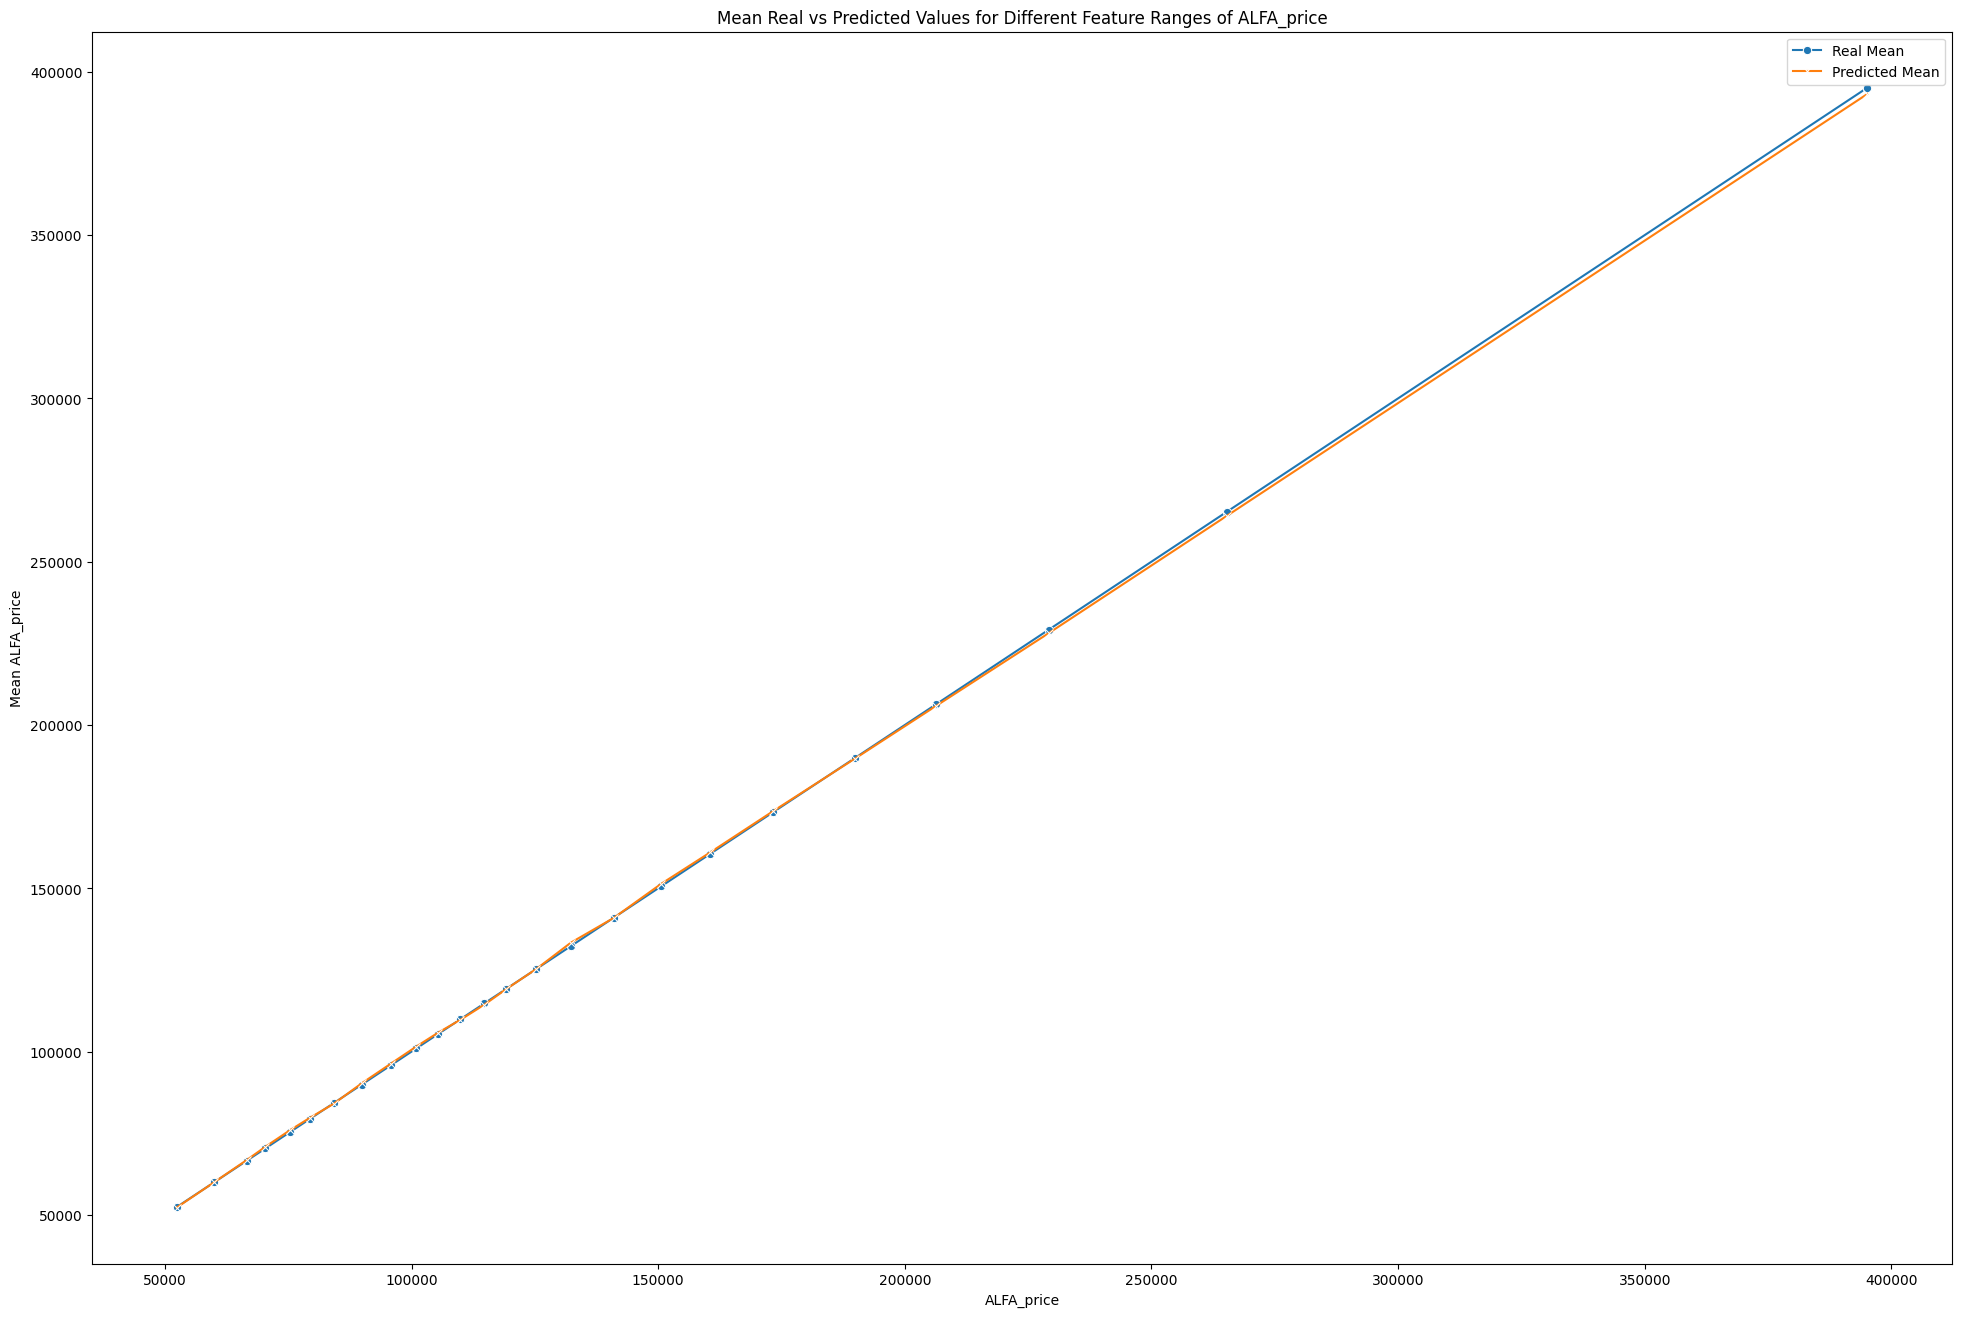

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def plot_real_vs_predicted_quantiles(data, predictions, feature, target_variable, num_quantiles=3):
    data['quantiles'] = pd.qcut(data[feature], num_quantiles, labels = False, duplicates = 'drop')
    data['predicted'] = predictions
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
    quantile_values = data.groupby('quantiles')[feature].mean().values

    mean_values = data.groupby('quantiles').agg({
        target_variable: 'mean',
        'predicted': 'mean'
    }).reset_index()
    
    plt.figure(figsize=(24, 16))
    sns.lineplot(x=quantile_values, y=mean_values[target_variable], label='Real Mean', marker='o')
    sns.lineplot(x=quantile_values, y=mean_values['predicted'], label='Predicted Mean', marker='x')

    plt.title(f'Mean Real vs Predicted Values for Different Feature Ranges of {feature}')
    plt.xlabel(feature)
    plt.ylabel(f'Mean {target_variable}')
    plt.legend()
    plt.show()

plot_real_vs_predicted_quantiles(data, utils.predict(model, data[features]), target_variable, target_variable, num_quantiles=25)

In [81]:
import os
from PIL import Image

def jpgs_to_pdf(image_dir, output_pdf_path):
    """
    Combines all JPG images in a directory into a single PDF.

    Args:
        image_dir (str): Path to the directory containing JPG images.
        output_pdf_path (str): Path to the output PDF file.

    Raises:
        ValueError: If the specified directory does not exist or contains no JPG images.
    """

    if not os.path.exists(image_dir):
        raise ValueError(f"Image directory does not exist: {image_dir}")

    image_paths = [
        os.path.join(image_dir, filename)
        for filename in os.listdir(image_dir)
        if filename.lower().endswith(".jpg")
    ]

    if not image_paths:
        raise ValueError(f"No JPG images found in directory: {image_dir}")

    images = [Image.open(path) for path in image_paths]

    with open(output_pdf_path, "wb") as pdf_file:
        images[0].save(
            pdf_file, "PDF", resolution=100.0, save_all=True, append_images=images[1:]
        )

# Example usa

In [82]:
jpg_directory = '../reports/netrisk_casco_2023_11_14__2023_11_20__2023_12_12_ALFA_price_model/resources/'
output_pdf = 'output_report.pdf'

# Call the function to create the PDF
jpgs_to_pdf(jpg_directory, output_pdf)


In [78]:
makePDF().output(PDF_PATH + TARGET_VARIABLE + '_summary.pdf')

NameError: name 'makePDF' is not defined

In [9]:
DATA

,Unnamed: 0,id_case,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,...,GENERALI_price,GENERTEL_price,GROUPAMA_price,K&AMP;H_price,KÖBE_price,MAGYAR_price,SIGNAL_price,UNION_price,UNIQA_price,WÁBERER_price
0,0,0,2023_11_14,True,10,2,998,49,899,15337.400,...,126131.0,NaN,102780.0,199264.0,100650.0,NaN,NaN,82175.0,115246.0,167196.0
1,1,1,2023_11_14,True,7,1,999,92,1280,24388.000,...,270092.0,NaN,142080.0,344622.0,116754.0,137964.0,NaN,146810.0,203799.0,NaN
2,2,2,2023_11_14,True,5,2,999,54,974,6757.400,...,229026.0,NaN,109356.0,163430.0,129564.0,100000.0,NaN,155078.0,150166.0,NaN
3,3,3,2023_11_14,True,9,2,998,49,996,8447.400,...,154209.0,NaN,178620.0,162550.0,100284.0,100000.0,NaN,81991.0,141611.0,NaN
4,4,4,2023_11_14,True,20,2,999,59,1270,11568.336,...,228020.0,NaN,134844.0,220854.0,120414.0,NaN,NaN,139700.0,162120.0,206956.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,3101,3101,2023_12_12,True,20,1,999,59,1270,11568.336,...,135708.0,NaN,84252.0,209469.0,68808.0,NaN,NaN,92977.0,78538.0,70340.0
3102,3102,3102,2023_12_12,True,19,6,999,44,940,NaN,...,89462.0,NaN,170136.0,NaN,75030.0,NaN,60468.0,NaN,110554.0,NaN
3103,3103,3103,2023_12_12,True,5,10,1598,77,1171,9152.000,...,110600.0,NaN,61884.0,92837.0,101382.0,100000.0,92535.0,65073.0,73726.0,59724.0
3104,3104,3104,2023_12_12,True,23,4,999,59,1120,11459.370,...,104352.0,NaN,98328.0,129331.0,68808.0,100000.0,NaN,89919.0,94041.0,89196.0


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations


def find_most_similar_rows(df):
    """
    Find the two most similar rows in a DataFrame with string columns.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.

    Returns:
    - tuple: Indices of the two most similar rows.
    """
    # Select only string columns for similarity computation
    string_columns = df.select_dtypes(include=['object']).columns
    df_strings = df[string_columns]

    # Initialize variables to store similarity and corresponding indices
    max_similarity = 0
    most_similar_indices = (0, 0)

    # Iterate through all pairs of rows
    for i, j in combinations(df_strings.index, 2):
        # Compute cosine similarity between rows i and j
        similarity = cosine_similarity([df_strings.loc[i]], [df_strings.loc[j]])[0, 0]

        # Update max_similarity and most_similar_indices if a higher similarity is found
        if similarity > max_similarity:
            max_similarity = similarity
            most_similar_indices = (i, j)

    return most_similar_indices

# Example usage:
# Assume you have a DataFrame named 'my_dataframe'.
# similar_indices = find_most_similar_rows(my_dataframe)
# print(similar_indices)

In [26]:
DATA = DATA[FEATURES + [TARGET_VARIABLE]]
DATA = DATA.dropna()

In [28]:
sims = cosine_similarity(DATA.values)

In [31]:
np.argsort(sims, axis=0)[-2:]

array([[ 865,  759,  620, ..., 2543, 2943, 2942],
       [   0,    1,    2, ..., 2941, 2942, 2943]])

In [32]:
DATA.iloc[865]

isRecent                True
CarMake                   10
CarAge                     2
ccm                      998
kw                        49
kg                       899
car_value            15337.4
CarMakerCategory         1.0
PostalCode              1013
PostalCode2               10
PostalCode3              101
Category                   2
Longitude            19.0404
Latitude             47.4984
Age                       40
LicenseAge                18
BonusMalus               0.0
BonusMalusCode             1
ALFA_price          156948.0
Name: 910, dtype: object

In [33]:
DATA.iloc[0]

isRecent                True
CarMake                   10
CarAge                     2
ccm                      998
kw                        49
kg                       899
car_value            15337.4
CarMakerCategory         1.0
PostalCode              1016
PostalCode2               10
PostalCode3              101
Category                   2
Longitude            19.0404
Latitude             47.4984
Age                       39
LicenseAge                18
BonusMalus               1.0
BonusMalusCode             2
ALFA_price          156948.0
Name: 0, dtype: object

In [34]:
DATA.iloc[569]

isRecent                True
CarMake                   22
CarAge                     8
ccm                     1329
kw                        73
kg                      1245
car_value            13494.0
CarMakerCategory        0.97
PostalCode              1037
PostalCode2               10
PostalCode3              103
Category                   2
Longitude            19.0404
Latitude             47.4984
Age                       33
LicenseAge                18
BonusMalus               0.0
BonusMalusCode             1
ALFA_price          146100.0
Name: 598, dtype: object

In [14]:
groups = []
for g, data in DATA.groupby(TARGET_VARIABLE):
    groups.append(data)

In [15]:
groups[0]

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price
1394,True,9,8,1248,62,1158,8317.4,0.97,2686,26,268,7,19.3876,47.851,45,18,1.0,2,41040.0


In [16]:
print([len(x) for x in groups])

[1, 2, 6, 1, 6, 9, 4, 2, 1, 2, 3, 51, 1, 2, 1, 2, 3, 12, 1, 6, 1, 1, 2, 1, 1, 2, 2, 11, 2, 1, 2, 1, 1, 2, 1, 1, 5, 5, 3, 1, 2, 3, 3, 12, 1, 5, 2, 1, 1, 7, 6, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 5, 1, 1, 10, 7, 4, 1, 1, 2, 6, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 6, 1, 1, 12, 14, 2, 3, 4, 1, 6, 21, 19, 6, 7, 2, 1, 3, 1, 1, 1, 2, 3, 1, 2, 4, 3, 5, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 4, 1, 1, 1, 2, 3, 1, 1, 2, 2, 3, 5, 4, 2, 2, 1, 4, 2, 2, 10, 1, 1, 6, 1, 1, 5, 2, 2, 4, 2, 1, 1, 1, 2, 2, 3, 1, 4, 3, 1, 1, 2, 7, 1, 15, 2, 3, 1, 1, 1, 1, 1, 1, 1, 11, 1, 2, 1, 2, 1, 9, 1, 1, 3, 1, 1, 1, 5, 18, 3, 13, 1, 1, 11, 1, 1, 2, 1, 1, 2, 3, 1, 5, 1, 1, 9, 1, 2, 2, 10, 3, 1, 2, 2, 4, 2, 1, 1, 5, 2, 1, 2, 1, 2, 1, 3, 4, 2, 5, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 1, 1, 3, 5, 1, 1, 5, 4, 3, 1, 10, 7, 2, 3, 4, 1, 1, 1, 1, 1, 1, 3, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 8, 6, 1, 1, 1, 3, 1, 1, 3, 2, 3, 1, 5, 1, 2, 1, 1, 1, 1, 7, 1, 1, 9, 1, 1, 9, 2, 1, 1, 1, 3, 1, 1

In [17]:
groups[11]

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price
182,True,21,5,998,50,805,8577.4,1.0,3022,30,302,6,19.6787,47.7330,80,18,3.0,4,53184.0
272,True,21,5,998,50,805,8577.4,1.0,4600,46,460,6,22.0833,48.2167,40,18,0.0,1,53184.0
287,True,21,5,998,50,805,8577.4,1.0,3552,35,355,7,20.9333,47.9833,40,18,0.0,1,53184.0
289,True,21,5,998,50,805,8577.4,1.0,6806,68,680,6,20.3333,46.4167,37,18,0.0,1,53184.0
482,True,21,4,998,50,805,8577.4,1.0,4502,45,450,7,21.8183,48.1179,42,18,0.0,1,53184.0
765,True,21,6,998,50,805,8577.4,1.0,4163,41,416,7,21.1500,47.2333,36,18,0.0,1,53184.0
774,True,21,5,998,50,805,8577.4,1.0,2646,26,264,7,19.0519,48.0472,46,18,0.0,1,53184.0
943,True,21,5,998,50,805,8577.4,1.0,2671,26,267,7,19.4107,48.0785,75,18,0.0,1,53184.0
954,True,21,4,998,50,805,8577.4,1.0,2463,24,246,4,18.7525,47.3440,46,18,0.0,1,53184.0
1018,True,21,7,998,50,805,8577.4,1.0,2453,24,245,4,18.8962,47.2519,36,18,0.0,1,53184.0


In [18]:
groups.sort(key=lambda x: -len(x))

In [19]:
groups[3].min(axis=0)

isRecent               True
CarMake                  21
CarAge                    9
ccm                     996
kw                       50
kg                      855
car_value            6497.4
CarMakerCategory        1.0
PostalCode             2464
PostalCode2              24
PostalCode3             246
Category                  2
Longitude           16.5905
Latitude            46.2517
Age                      38
LicenseAge               18
BonusMalus              0.0
BonusMalusCode            1
ALFA_price          68280.0
dtype: object

In [20]:
groups[0].max(axis=0).astype(int) - groups[0].min(axis=0).astype(int)

isRecent               0
CarMake                0
CarAge                 3
ccm                    0
kw                     0
kg                     0
car_value              0
CarMakerCategory       0
PostalCode          7618
PostalCode2           76
PostalCode3          762
Category               5
Longitude              6
Latitude               2
Age                   49
LicenseAge             0
BonusMalus             3
BonusMalusCode         3
ALFA_price             0
dtype: int64

In [21]:
car_value_groups = []
for g, group in DATA.groupby('car_value'):
    car_value_groups.append(group)

In [23]:
[len(x) for x in car_value_groups]

[24,
 9,
 1,
 33,
 3,
 3,
 36,
 16,
 17,
 21,
 3,
 4,
 63,
 11,
 30,
 22,
 3,
 8,
 20,
 5,
 1,
 2,
 28,
 21,
 6,
 3,
 3,
 15,
 10,
 7,
 2,
 1,
 5,
 7,
 2,
 63,
 4,
 3,
 120,
 7,
 5,
 15,
 2,
 6,
 1,
 1,
 2,
 27,
 1,
 2,
 26,
 21,
 1,
 47,
 25,
 2,
 22,
 10,
 41,
 7,
 22,
 1,
 10,
 6,
 1,
 6,
 11,
 1,
 3,
 7,
 1,
 8,
 7,
 3,
 2,
 19,
 22,
 5,
 4,
 2,
 5,
 16,
 2,
 24,
 4,
 5,
 4,
 1,
 36,
 1,
 1,
 17,
 87,
 12,
 15,
 8,
 3,
 3,
 1,
 8,
 52,
 4,
 2,
 3,
 6,
 2,
 11,
 1,
 5,
 2,
 7,
 4,
 1,
 3,
 9,
 12,
 17,
 9,
 2,
 33,
 2,
 20,
 1,
 4,
 16,
 23,
 15,
 1,
 26,
 1,
 4,
 9,
 2,
 17,
 5,
 1,
 6,
 8,
 1,
 3,
 3,
 6,
 1,
 41,
 5,
 15,
 12,
 3,
 14,
 19,
 1,
 1,
 1,
 18,
 8,
 4,
 2,
 1,
 3,
 24,
 4,
 1,
 1,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 8,
 3,
 18,
 3,
 1,
 1,
 4,
 2,
 9,
 3,
 72,
 1,
 5,
 3,
 17,
 51,
 5,
 14,
 3,
 25,
 3,
 8,
 5,
 2,
 8,
 2,
 60,
 1,
 9,
 7,
 7,
 12,
 29,
 60,
 3,
 10,
 1,
 2,
 6,
 1,
 8,
 2,
 86,
 1,
 2,
 5,
 3,
 6,
 1,
 23,
 22,
 13,
 1,
 1,
 2,
 21,
 13,
 1,
 2,
 15,
 2,
 

In [34]:
mx_diffs = {}
for feature in FEATURES:
    mx_dif = -1
    for group in groups:
        cur_dif = group[feature].max().astype(float) - group[feature].min().astype(float)
        if cur_dif > mx_dif:
            mx_dif = cur_dif
            mx_diffs[feature] = (group[feature].min().astype(float), group[feature].max().astype(float))


In [35]:
mx_diffs

{'isRecent': (1.0, 1.0),
 'CarMake': (6.0, 23.0),
 'CarAge': (2.0, 10.0),
 'ccm': (999.0, 2359.0),
 'kw': (55.0, 127.0),
 'kg': (1023.0, 1868.0),
 'car_value': (14883.544, 38217.4),
 'CarMakerCategory': (0.97, 1.0),
 'PostalCode': (1046.0, 9821.0),
 'PostalCode2': (10.0, 98.0),
 'PostalCode3': (104.0, 982.0),
 'Category': (1.0, 7.0),
 'Longitude': (16.4608, 22.3658),
 'Latitude': (45.8392, 48.3451),
 'Age': (22.0, 78.0),
 'LicenseAge': (18.0, 18.0),
 'BonusMalus': (0.0, 10.0),
 'BonusMalusCode': (1.0, 11.0)}

In [36]:
DATA[DATA['car_value'] == 14883.544]

,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,ALFA_price
155,True,1,5,999,70,1090,14883.544,1.0,2764,27,276,5,19.6861,47.3610,42,18,0.0,1,169020.0
508,True,1,5,999,70,1090,14883.544,1.0,2508,25,250,4,18.7415,47.7928,23,18,0.0,1,270648.0
1205,True,1,5,999,70,1090,14883.544,1.0,1048,10,104,1,19.0404,47.4984,83,18,0.0,1,204804.0
1821,True,1,5,999,70,1090,14883.544,1.0,8191,81,819,7,18.0733,47.1600,53,18,0.0,1,139188.0
1846,True,1,6,999,70,1090,14883.544,1.0,6222,62,622,7,19.2680,46.7154,71,18,0.0,1,139188.0
1914,True,1,5,999,70,1090,14883.544,1.0,1072,10,107,1,19.0404,47.4984,42,18,0.0,1,204804.0
2033,True,1,6,999,70,1090,14883.544,1.0,3426,34,342,7,20.7000,47.9500,36,18,0.0,1,139188.0
2082,True,1,5,999,70,1090,14883.544,1.0,7784,77,778,5,18.5785,45.9443,48,18,7.0,8,139188.0
2095,True,1,5,999,70,1090,14883.544,1.0,9092,90,909,5,17.7833,47.5000,57,18,0.0,1,139188.0
2245,True,1,5,999,70,1090,14883.544,1.0,2643,26,264,5,19.0432,47.9397,33,18,7.0,8,154656.0


In [37]:
DATA[TARGET_VARIABLE].nunique()

1433

In [38]:
len(groups)

1433

In [ ]:
len([x for x in groups if len(x) > 11])